# Tutorial for $n=7$ spin

In this notebook it is showed a step-by-step procedure for generating data, training models and compare exact results and predictions. We will concentrate on time-independent local generators for systems with periodic boundary conditions.
The first thing to do is to set-up the parameters in the headers of the code, keep in mind that the parameters used must be the same for all the steps (data generation, training, test).

## Data generation

The file for generating data is named ''create_data_thermal_PBC.py''. We set the sollowing parameters in the header:

default_parameters =  
                      
                      {'model_dir': './results/data_th_periodic/T_10',
                      'system': {
                      'n_spins': 7,  # system size
                      'beta': [0],
                      'potential': [0.1],
                      'Rabi': 1,
                      'Delta': 0,

                         },
                      'dt': 0.01,  # time step
                      'time': 10,  # total time of the evolution
                      'num_trajectories': 20,  # number
                      'seed': None
                      }"
 i.e. 20 trajectories (starting from 20 different initial states), $\beta=0.1$, $V=0.1\Omega$.

### Here the code

In [120]:
#You may need to install some libraries
#the usual procedure on terminal is (if you have anaconda, suggested)
#$ conda install -c conda-forge name_of_library (e.g. tensorboardx)
import scipy.sparse.linalg as spa
import scipy.sparse as sps
from ml.utils import update_params_from_cmdline, save_metrics_params, ensure_dir, xmap
import os
from physics.FSS_dyn.ED_b import *
import deepdish as dd
from s_const import *
from multiprocessing import Pool, cpu_count
import opt_einsum as oe
import scipy.linalg as LA
default_parameters = {'model_dir': './results/data_th_periodic/T_10/two_bodies',
                      'system': {
                          'n_spins': 7,#,  # system size
                           'beta': [0.1],
                           'potential': [0.1],
                           'Rabi': 1,
                           'Delta': 0,

                      },
                      'dt': 0.01,  # time step
                      'time': 10,  # total time of the evolution
                      'num_trajectories': 20,  # number
                      'seed': None
                      }




In [121]:
#**********  BASIC MATRIX DEFINITIONS  **********
#
#
#
sigma_x = np.array( [ [ 0. , 1. ] , [ 1. , 0. ] ] )
N = np.array( [ [ 0. , 0. ] , [ 0. , 1. ] ] )
sigma_z = np.array( [ [ 1. , 0. ] , [ 0. , -1. ] ] )
sigma_y = np.array([[0, -1j], [1j, 0]])
Pj = np.array( [ [ 1. , 0. ] , [ 0. , 0. ] ] )
nf = np.array([[1, 0],[0, 0]]) ###  local fermions number nf = 1-sz ###
Id = np.eye(2).astype(np.float64)

pauli_dict = {
    'X': sigma_x,
    'Y': sigma_y,
    'Z': sigma_z,
    'I': Id
}
names=['I','X','Y','Z']

observables_dict={}

def pauli_op(sites,L):
 paulis2=[]
 names_pauli2=[]
 for i in names:
  for j in names:
     names_pauli2.append(i+str(sites[0])+j+str(sites[1]))
     paulis2.append(two_FF(pauli_dict[i],pauli_dict[j],sites[0],sites[1],L))
 return paulis2, names_pauli2

#THIS IS THE FUNCTION WHICH GENERATES THE TRAJECTORIES STARTING FROM RANDOM INITIAL STATES
def compute_traj2(sites, beta, dt, T):
    paulis2, names_pauli2 = pauli_op(sites,L)
    nstep = int(T / dt)
    H_Rabi_th = H1f(sigma_x, L - 2)
    H_Detuning_th = H1f(nf, L - 2)
    H_int_th = H2srdef(nf, nf, L - 2)
    H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
    bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )
    rho_loc=np.array([np.random.normal() for i in range(16)]).reshape(4,4)+1j*np.array([np.random.normal() for i in range(16)]).reshape(4,4)
    rho_loc=rho_loc.dot(rho_loc.conjugate().transpose())
    rho_loc=rho_loc/rho_loc.trace()
    
    rho = np.kron(rho_loc, bath.toarray())
    for i in range(len(names_pauli2)):
        observables_dict[names_pauli2[i]]=((paulis2[i].dot(rho).diagonal().sum())/ 
                                           rho.diagonal().sum()).real

    arr = [[ observables_dict[key] for key in observables_dict.keys()  ][1:]]
    print(arr)
    temp = [ 0.0 ]
    rho_tilde = np.conj(U.T) @ rho @ U
    pa_ti = np.array([pa.toarray() for pa in paulis2])
    pauli2_tilde = np.conj(U.T) @ pa_ti @ U
    for i in range( 1, nstep ):
        ee = np.exp(-1j*e*dt*i)
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)
        rho_in = rho_in
        trace = lambda k: ((oe.contract( 'ij,ji->', pauli2_tilde[k],rho_in ))/ rho_in.diagonal().sum()).real
        obs = [trace(k) for k in range(len( names_pauli2 ) )]
        #obs = xmap(trace,range(len( names_pauli2 ) ))
        time = i * dt
        arr.append( obs[1:] )
        temp.append( i * dt )
    print("finished Time = %s" % T)
    return np.asarray(arr[:-1]).astype(np.float32), \
           np.asarray(arr[1:]).astype(np.float32), \
           np.asarray(temp[:-1]).astype(np.float32), \
           np.expand_dims(np.asarray(arr[0]).astype(np.float32), 0), \
           np.expand_dims(np.asarray(arr[-1]).astype(np.float32), 0)

In [122]:
cfg = default_parameters
L = cfg["system"]["n_spins"]
Omega = cfg["system"]["Rabi"]
for k in range(len(cfg["system"]["potential"])):
        for j in range(len(cfg["system"]["beta"])):
            C_def = cfg["system"]["potential"][k]
            Delta = cfg["system"]["Delta"]
            beta = cfg["system"]["beta"][j]


            print("----Generating trajectories for impurity = %s" % C_def)


            H_Rabi = H1f(sigma_x, L)
            H_Detuning = H1f(nf, L)
            H_int = H3srdef(nf, nf, L)
            H_def = H3srdef1(nf, nf, L)
            T = cfg["time"]
            dt = cfg["dt"]
            nstep = int(T/dt)
            time = np.linspace(0 , T-2*dt , nstep - 1 , endpoint = True)

            sites = [1,2]

    
            H = ( Omega/2 )*H_Rabi + Delta*H_Detuning + H_int + C_def*H_def
    

            e, U = LA.eigh(H.toarray())
            print("diagonalized")
            ensure_dir(cfg["model_dir"])

            if cfg["seed"] is not None:
                np.random.seed(cfg["seed"])

            trajectories = {}
            trajectories['p_t1'] = None
            trajectories['p_t2'] = None
            trajectories['t'] = None

            trajectories_eval_fin = {}
            trajectories_eval_fin['p_0'] = None
            trajectories_eval_fin['p_T'] = None

            for i in range(cfg["num_trajectories"]):
                print(f"trajectory: {i}")
                random_state= np.random.randint(0, 2**L)
                p_t1, p_t2, t, p_0, p_T = compute_traj2(sites, beta ,cfg["dt"], cfg["time"])

                if trajectories['p_t1'] is None:
                    trajectories['p_t1'] = p_t1
                    trajectories['p_t2'] = p_t2
                    trajectories['t'] = t
                    trajectories_eval_fin['p_0'] = p_0
                    trajectories_eval_fin['p_T'] = p_T
                else:
                    trajectories['p_t1'] = np.concatenate((trajectories['p_t1'], p_t1), 0)
                    trajectories['p_t2'] = np.concatenate((trajectories['p_t2'], p_t2), 0)
                    trajectories['t'] = np.concatenate((trajectories['t'], t), 0)
                    trajectories_eval_fin['p_0'] = np.concatenate((trajectories_eval_fin['p_0'], p_0), 0)
                    trajectories_eval_fin['p_T'] = np.concatenate((trajectories_eval_fin['p_T'], p_T), 0)
            
            path = os.path.join(cfg["model_dir"], f"traj_fss_dyn_{beta}_{C_def}_{L}_dt_{dt}_two_bodies_diag_gm.h5")
            path_eval_fin = os.path.join(cfg["model_dir"], f"traj_fss_final_{beta}_{C_def}_{L}_dt_{dt}_two_bodies_diag_gm.h5")
          
            print([v.shape for k, v in trajectories.items()])
            print(f"saving to {path}")
            dd.io.save(path, trajectories)
            dd.io.save(path_eval_fin, trajectories_eval_fin)
            print("done")
            metrics = {'dummy': 0}

----Generating trajectories for impurity = 0.1
diagonalized
trajectory: 0
[[0.22605337418815427, 0.04044088927027454, 0.21101249257144175, 0.3073195898140276, 0.32498008303252074, 0.18938076265536763, 0.1525782724143607, -0.18426850549415216, -0.0885794907406628, -0.4284913042473599, -0.08644536741464079, -0.007061284479143783, 0.13610454468916322, 0.2068176513918428, -0.03535557455028913]]
finished Time = 10
trajectory: 1
[[-0.21918557235551017, 0.04674952150497587, -0.14693592578966808, 0.40334038013501555, -0.5517521864572734, 0.06332253513364428, -0.14093655590290674, 0.12150952150781846, -0.10252301100054703, 0.21423103651073225, -0.10730021452528715, -0.11499536692981588, -0.10349574255702915, 0.05750761000702037, 0.3542684492452577]]
finished Time = 10
trajectory: 2
[[0.0018831915877591116, 0.22469241472461224, 0.019985671126765053, 0.047309678758585924, -0.17752406875364435, 0.24828829642079872, -0.127590740329263, -0.042215174972483026, 0.4578532718385363, 0.1164667500842283, 

Some warnings about sparse efficiency may occur, they do not inficiate the correctness of the data generation.

## Train, evaluate and save the model

In this case in the header we must also specify the value of the parameters (which will be used to call the datasets saved) and the architecture of the model. We must also specify: the number of epochs, the size of every batch and the number of batches per epoch. The file is named "train_PBC.py".

### Here the code

In [123]:
#SAME HERE YOU MAY NEED TO INSTALL SMTH
from ml.utils import update_params_from_cmdline, save_metrics_params, ensure_dir, ensure_empty_dir, infinite_dataset
from torch.utils.data import Dataset, DataLoader
from ml.pytorch_modules.vae import BVAE
from ml.pytorch_modules.dynamics_mlp import MLP,MLLP
from torch import optim
from train_data import *
from utils.settings import cfg
import os
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import l4
import sfw
import sys

In [131]:
#Parameters of the model
default_parameters = {'model_dir': './results/test1',
                      'n_spins': 7,
                      'batch_size': 256,
                      'batches_per_epoch': 256,
                      'n_epochs': 25,
                      'beta': [0.1],
                      'potential': [0.1],
                      'device': 'cpu',
                      'dt': 0.01,
                      'MLP_pr': {
                      		'mlp_params': {
                          		'data_dim': 15,
                          		'layers': [ ],
                                        'nonlin': 'id',
                                        'output_nonlin': 'id',
                                        'dt': 0.01
                                        },
                                },
                      }
#In order to visualize the training live just type on the terminal "tensorboard --logdir=./results/test1" logdir is the model_dir

In [132]:
#**************** THIS DEFINES THE TRAINING PROCEDURE********************
def train(model, optimizer, data_loader, batches_per_epoch, epoch ):#, #writer):
    model.train()
    summed_train_loss = 0.
    for batch_idx in range(batches_per_epoch):
        constraints = sfw.constraints.create_simplex_constraints(model)
        (batch_in, batch_out) = next(data_loader)
        data_in = batch_in.float().to(cfg["device"])
        data_out = batch_out.float().to(cfg["device"])
        optimizer.zero_grad()
        recon_batch = model(data_in)
        loss = model.loss(data_out, recon_batch)
        summed_train_loss += loss.item()
        loss.backward()
        optimizer.step(constraints)

    print('=== Mean train loss: {:.12f}'.format(summed_train_loss / batches_per_epoch))
    return model, optimizer



In [133]:
#**************** THIS DEFINES THE EVALUATION PROCEDURE********************

def eval(data_loader, model, batch_idx ):#, #writer):
    model.eval()
    summed_eval_loss = 0.
    summed_eval_test_loss = 0.
    batches_per_eval = 100
    for i in range(batches_per_eval):
        (batch_in, batch_out) = next(data_loader)
        data_in = batch_in.float().to(cfg["device"])
        data_out = batch_out.float().to(cfg["device"])
        recon_batch = model(data_in)
        eval_loss = model.loss(data_out, recon_batch).item()
        summed_eval_loss += eval_loss

    #writer.add_scalar('eval_loss', summed_eval_loss / batches_per_eval, batch_idx)
    print('=== Test set loss: {:.12f}'.format(summed_eval_loss / batches_per_eval))
    return {'loss': summed_eval_loss}

In [134]:
    #cfg = update_params_from_cmdline(default_params=default_parameters)
cfg = default_parameters


ensure_dir(cfg['model_dir'])
ensure_empty_dir(cfg['model_dir'])
L = cfg["n_spins"]

    for k in range(len(cfg["beta"])):
        for j in range(len(cfg["potential"])):
            beta = cfg["beta"][k]
            C = cfg["potential"][j]
            dt = cfg["MLP_pr"]["mlp_params"]["dt"]
            print('===Training model for beta = %s and C = %s' %(beta, C))
            data_train = Data_p_train("./results/data_th_periodic/T_10/two_bodies/traj_fss_dyn_%s_%s_%s_dt_%s_two_bodies_diag_gm.h5" %(beta, C,L,dt))
            data_eval = Data_p_eval("./results/data_th_periodic/T_10/two_bodies/traj_fss_dyn_%s_%s_%s_dt_%s_two_bodies_diag_gm.h5" %(beta, C,L,dt))
            train_loader = DataLoader(dataset=data_train, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)
            train_loader = infinite_dataset(train_loader)
            eval_loader = DataLoader(dataset=data_eval, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)
            eval_loader = infinite_dataset(eval_loader)
        #    #writer = SummaryWriter(os.path.join(cfg.model_dir, 'tensorboard'))
            model = MLLP(**cfg["MLP_pr"]).to(cfg["device"])
            optimizer = sfw.optimizers.Adam(model.parameters() ,lr =0.01)#optim.Adam(model.parameters(), lr=0.01)
            #wrap = l4.L4(optimizer )
            for epoch in range(cfg["n_epochs"]):
                 print('= Starting epoch ', epoch, '/', cfg["n_epochs"])
                 model, optimizer = train(model, optimizer, train_loader, cfg["batches_per_epoch"], epoch )#, #writer)
                 metrics = eval(eval_loader, model, cfg["batches_per_epoch"]* epoch )#, #writer)
 
            #save_metrics_params(metrics, cfg)


            torch.save(model.state_dict(), './trained_models/PBC/Thermal/eff__Cdef_%s_beta_%s_L_%s_dt_%s_two_bodies_LL' %(C, beta,L,dt))
            print('saved to ./trained_models/PBC/Thermal/eff__Cdef_%s_beta_%s_L_%s_dt_%s_two_bodies_LL' %(C, beta,L,dt))


===Training model for beta = 0.1 and C = 0.1
= Starting epoch  0 / 25
=== Mean train loss: 0.002154530179
=== Test set loss: 0.000000461206
= Starting epoch  1 / 25
=== Mean train loss: 0.000000132379
=== Test set loss: 0.000000074718
= Starting epoch  2 / 25
=== Mean train loss: 0.000000029198
=== Test set loss: 0.000000024252
= Starting epoch  3 / 25
=== Mean train loss: 0.000000010671
=== Test set loss: 0.000000010435
= Starting epoch  4 / 25
=== Mean train loss: 0.000000004873
=== Test set loss: 0.000000005254
= Starting epoch  5 / 25
=== Mean train loss: 0.000000002525
=== Test set loss: 0.000000002920
= Starting epoch  6 / 25
=== Mean train loss: 0.000000001426
=== Test set loss: 0.000000001726
= Starting epoch  7 / 25
=== Mean train loss: 0.000000000855
=== Test set loss: 0.000000001079
= Starting epoch  8 / 25
=== Mean train loss: 0.000000000537
=== Test set loss: 0.000000000702
= Starting epoch  9 / 25
=== Mean train loss: 0.000000000350
=== Test set loss: 0.000000000473
= Sta

Now, we saved the model in the path speficied by the command "torch.save()". Note that the path of the model is speficied also by the value of the parameters

## Test
We can test the model by loading it and compare the performace of exact evolution. Please keep in mind that in the header the parameters of the model must be the same used for the training. We will condiser $T_{max}>T_{train}$

### Here the code

In [135]:
## Parameters
L = 7
dt = 0.01
T = 20
nstep = int(T/dt)
Omega = 1.0
Delta = 0
C = 0.1
C_def = 0.1
sites = [1,2]
beta = 0.1



In [136]:
# Parameters of the header
default_parameters_test = {'device': 'cpu',
                      'MLLP_par': {
                      		'mlp_params': {
                          		'data_dim': 15,
                          		'layers':  [ ],
                              'nonlin': 'id',
                              'output_nonlin': 'id'
                          					},
                          },
                      }

## Test

In [137]:
conf = default_parameters_test   

model = MLLP(**conf['MLLP_par']).to(conf['device'])#we load the blueprint of the model
model.load_state_dict(torch.load('trained_models/PBC/Thermal/eff__Cdef_%s_beta_%s_L_%s_dt_%s_two_bodies_LL' %(C, beta,L,dt)))

paulis2, names_pauli2 = pauli_op(sites,L)

nstep = int(T / dt)
H_Rabi_th = H1f(sigma_x, L - 2)
H_Detuning_th = H1f(nf, L - 2)
H_int_th = H2srdef(nf, nf, L - 2)
H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )
rho_loc=np.array([np.random.normal() for i in range(16)]).reshape(4,4)+1j*np.array([np.random.normal() for i in range(16)]).reshape(4,4)
rho_loc=rho_loc.dot(rho_loc.conjugate().transpose())
rho_loc=rho_loc/rho_loc.trace()
observables_dict ={}
rho = np.kron(rho_loc, bath.toarray())
for i in range(len(names_pauli2)):
        observables_dict[names_pauli2[i]]=((paulis2[i].dot(rho).diagonal().sum())/ 
                                           rho.diagonal().sum()).real

arr = [[ observables_dict[key] for key in observables_dict.keys()  ][1:]]
print(arr)
v_in = torch.tensor(arr[0]).float()
temp1 = [v_in.numpy()]

print(v_in)
temp = [ 0.0 ]

print("Building Hamiltonian for L=%s" %(L))

H_Rabi = H1f(sigma_x, L)
H_Detuning = H1f(nf, L)
H_int = H3srdef(nf, nf, L)
H_def = H3srdef1(nf, nf, L)
nstep = int(T/dt)
sites = [1,2]
H = ( Omega/2 )*H_Rabi + Delta*H_Detuning + H_int + C_def*H_def
e, U = LA.eigh(H.toarray())

#Exact Evolution

rho_tilde = np.conj(U.T) @ rho @ U
pa_ti = np.array([pa.toarray() for pa in paulis2])
pauli2_tilde = np.conj(U.T) @ pa_ti @ U
print(pauli2_tilde.shape)
for i in range( 1, nstep ):
        ee = np.exp(-1j*e*dt*i)
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)
        trace = lambda k: ((oe.contract( 'ij,ji->', pauli2_tilde[k],rho_in ))/ rho_in.diagonal().sum()).real
        obs = [ (pauli2_tilde[k]@rho_in).diagonal().sum().real for k in range(len( names_pauli2 ) )]
        #obs = xmap(trace,range(len( names_pauli2 ) ))
        time = i * dt
        print(time)
        arr.append( obs[1:] )
        temp.append( i * dt )
        #Evolution with model
        with torch.no_grad():
         v_out = model(v_in.float())
         v_in = v_out
         print(v_in)
         temp1.append(v_in.numpy())


[[0.2749483049696744, 0.11651830619437654, 0.06878921291630938, -0.11004579376151105, 0.1399691992902482, 0.007260680424374258, -0.01169609199334359, 0.2662471763276726, 0.3828704948278425, 0.1471605487036754, 0.265567763252543, -0.13639745378642631, 0.05984536465389412, -0.11639869522395786, 0.194175079109612]]
tensor([ 0.2749,  0.1165,  0.0688, -0.1100,  0.1400,  0.0073, -0.0117,  0.2662,
         0.3829,  0.1472,  0.2656, -0.1364,  0.0598, -0.1164,  0.1942])
Building Hamiltonian for L=7
(16, 128, 128)
0.01
tensor([ 0.2749,  0.1161,  0.0700, -0.1104,  0.1396,  0.0074, -0.0120,  0.2675,
         0.3822,  0.1461,  0.2650, -0.1337,  0.0637, -0.1167,  0.1957])
0.02
tensor([ 0.2748,  0.1157,  0.0711, -0.1108,  0.1392,  0.0075, -0.0123,  0.2687,
         0.3815,  0.1450,  0.2644, -0.1310,  0.0676, -0.1170,  0.1971])
0.03
tensor([ 0.2747,  0.1153,  0.0723, -0.1112,  0.1388,  0.0076, -0.0127,  0.2698,
         0.3808,  0.1439,  0.2638, -0.1283,  0.0715, -0.1173,  0.1986])
0.04
tensor([ 0.274

0.56
tensor([ 0.2722,  0.0806,  0.1254, -0.1322,  0.1196,  0.0188, -0.0259,  0.2906,
         0.2906,  0.1080,  0.2017,  0.0239,  0.2578, -0.1585,  0.2526])
0.5700000000000001
tensor([ 0.2722,  0.0797,  0.1262, -0.1326,  0.1193,  0.0191, -0.0261,  0.2902,
         0.2880,  0.1079,  0.2002,  0.0268,  0.2608, -0.1595,  0.2530])
0.58
tensor([ 0.2721,  0.0788,  0.1269, -0.1329,  0.1190,  0.0193, -0.0262,  0.2897,
         0.2854,  0.1078,  0.1986,  0.0297,  0.2638, -0.1606,  0.2534])
0.59
tensor([ 0.2721,  0.0780,  0.1277, -0.1333,  0.1187,  0.0196, -0.0263,  0.2893,
         0.2827,  0.1077,  0.1971,  0.0326,  0.2668, -0.1616,  0.2538])
0.6
tensor([ 0.2721,  0.0771,  0.1285, -0.1337,  0.1184,  0.0199, -0.0265,  0.2888,
         0.2800,  0.1077,  0.1955,  0.0355,  0.2697, -0.1627,  0.2541])
0.61
tensor([ 0.2721,  0.0762,  0.1293, -0.1341,  0.1181,  0.0202, -0.0266,  0.2882,
         0.2773,  0.1076,  0.1939,  0.0383,  0.2726, -0.1637,  0.2544])
0.62
tensor([ 0.2721,  0.0753,  0.1300, -0.13

1.2
tensor([ 0.2740,  0.0158,  0.1570, -0.1528,  0.1055,  0.0361, -0.0260,  0.2090,
         0.0750,  0.1438,  0.1119,  0.1892,  0.3889, -0.2111,  0.2301])
1.21
tensor([ 0.2741,  0.0147,  0.1572, -0.1531,  0.1054,  0.0363, -0.0258,  0.2069,
         0.0710,  0.1449,  0.1109,  0.1912,  0.3899, -0.2114,  0.2291])
1.22
tensor([ 0.2741,  0.0136,  0.1573, -0.1533,  0.1053,  0.0365, -0.0257,  0.2048,
         0.0671,  0.1460,  0.1100,  0.1933,  0.3907, -0.2117,  0.2281])
1.23
tensor([ 0.2742,  0.0125,  0.1575, -0.1535,  0.1052,  0.0367, -0.0255,  0.2027,
         0.0631,  0.1471,  0.1091,  0.1953,  0.3916, -0.2120,  0.2270])
1.24
tensor([ 0.2743,  0.0114,  0.1576, -0.1538,  0.1051,  0.0369, -0.0253,  0.2005,
         0.0591,  0.1482,  0.1082,  0.1973,  0.3924, -0.2122,  0.2260])
1.25
tensor([ 0.2744,  0.0103,  0.1577, -0.1540,  0.1050,  0.0371, -0.0252,  0.1984,
         0.0551,  0.1493,  0.1073,  0.1993,  0.3931, -0.2124,  0.2250])
1.26
tensor([ 0.2745,  0.0092,  0.1578, -0.1543,  0.1049,  

1.72
tensor([ 0.2792, -0.0407,  0.1504, -0.1623,  0.1048,  0.0431, -0.0136,  0.0788,
        -0.1345,  0.2022,  0.0921,  0.2652,  0.3837, -0.1972,  0.1716])
1.73
tensor([ 0.2793, -0.0418,  0.1500, -0.1624,  0.1049,  0.0432, -0.0133,  0.0760,
        -0.1384,  0.2032,  0.0923,  0.2660,  0.3825, -0.1963,  0.1705])
1.74
tensor([ 0.2795, -0.0428,  0.1496, -0.1625,  0.1050,  0.0432, -0.0130,  0.0731,
        -0.1423,  0.2041,  0.0925,  0.2667,  0.3813, -0.1955,  0.1695])
1.75
tensor([ 0.2796, -0.0438,  0.1491, -0.1626,  0.1051,  0.0432, -0.0127,  0.0703,
        -0.1462,  0.2050,  0.0928,  0.2674,  0.3801, -0.1946,  0.1685])
1.76
tensor([ 0.2797, -0.0448,  0.1487, -0.1627,  0.1052,  0.0433, -0.0124,  0.0674,
        -0.1501,  0.2059,  0.0930,  0.2681,  0.3788, -0.1937,  0.1675])
1.77
tensor([ 0.2798, -0.0458,  0.1482, -0.1628,  0.1053,  0.0433, -0.0120,  0.0646,
        -0.1540,  0.2068,  0.0933,  0.2688,  0.3775, -0.1928,  0.1665])
1.78
tensor([ 0.2800, -0.0469,  0.1478, -0.1629,  0.1054, 

tensor([ 0.2868, -0.0912,  0.1120, -0.1645,  0.1156,  0.0394,  0.0048, -0.0857,
        -0.3288,  0.2244,  0.1260,  0.2626,  0.2587, -0.1303,  0.1376])
2.3000000000000003
tensor([ 0.2869, -0.0919,  0.1111, -0.1645,  0.1159,  0.0392,  0.0051, -0.0885,
        -0.3315,  0.2241,  0.1268,  0.2617,  0.2556, -0.1290,  0.1376])
2.31
tensor([ 0.2871, -0.0926,  0.1101, -0.1645,  0.1162,  0.0391,  0.0054, -0.0912,
        -0.3341,  0.2238,  0.1276,  0.2608,  0.2524, -0.1277,  0.1376])
2.32
tensor([ 0.2872, -0.0933,  0.1092, -0.1644,  0.1164,  0.0389,  0.0057, -0.0940,
        -0.3367,  0.2235,  0.1284,  0.2598,  0.2492, -0.1265,  0.1376])
2.33
tensor([ 0.2873, -0.0940,  0.1083, -0.1644,  0.1167,  0.0388,  0.0060, -0.0968,
        -0.3393,  0.2231,  0.1291,  0.2589,  0.2460, -0.1252,  0.1376])
2.34
tensor([ 0.2875, -0.0946,  0.1073, -0.1644,  0.1170,  0.0386,  0.0064, -0.0995,
        -0.3418,  0.2228,  0.1299,  0.2579,  0.2428, -0.1240,  0.1377])
2.35
tensor([ 0.2876, -0.0953,  0.1064, -0.1643, 

2.92
tensor([ 0.2955, -0.1183,  0.0443, -0.1585,  0.1375,  0.0257,  0.0220, -0.2327,
        -0.4246,  0.1715,  0.1554,  0.1582,  0.0223, -0.0769,  0.1672])
2.93
tensor([ 0.2957, -0.1184,  0.0431, -0.1583,  0.1379,  0.0255,  0.0222, -0.2344,
        -0.4248,  0.1704,  0.1554,  0.1558,  0.0182, -0.0767,  0.1680])
2.94
tensor([ 0.2958, -0.1186,  0.0420, -0.1582,  0.1382,  0.0252,  0.0224, -0.2361,
        -0.4250,  0.1692,  0.1553,  0.1535,  0.0141, -0.0765,  0.1688])
2.95
tensor([ 0.2960, -0.1187,  0.0408, -0.1580,  0.1386,  0.0250,  0.0227, -0.2377,
        -0.4251,  0.1680,  0.1553,  0.1511,  0.0100, -0.0763,  0.1695])
2.96
tensor([ 0.2961, -0.1188,  0.0396, -0.1578,  0.1390,  0.0247,  0.0229, -0.2394,
        -0.4252,  0.1668,  0.1552,  0.1487,  0.0058, -0.0762,  0.1703])
2.97
tensor([ 0.2962, -0.1189,  0.0384, -0.1577,  0.1394,  0.0245,  0.0231, -0.2410,
        -0.4252,  0.1656,  0.1550,  0.1463,  0.0017, -0.0761,  0.1711])
2.98
tensor([ 0.2964, -0.1189,  0.0372, -0.1575,  0.1398, 

3.49
tensor([ 0.3036, -0.1100, -0.0219, -0.1474,  0.1590,  0.0105,  0.0320, -0.2883,
        -0.3702,  0.1140,  0.1248,  0.0053, -0.2024, -0.1001,  0.2018])
3.5
tensor([ 0.3037, -0.1096, -0.0230, -0.1472,  0.1594,  0.0102,  0.0322, -0.2884,
        -0.3681,  0.1134,  0.1238,  0.0024, -0.2059, -0.1011,  0.2020])
3.5100000000000002
tensor([ 0.3038, -0.1091, -0.0240, -0.1469,  0.1597,  0.0099,  0.0323, -0.2885,
        -0.3660,  0.1128,  0.1229, -0.0005, -0.2094, -0.1020,  0.2022])
3.52
tensor([ 0.3040, -0.1087, -0.0251, -0.1467,  0.1600,  0.0097,  0.0324, -0.2887,
        -0.3638,  0.1122,  0.1219, -0.0034, -0.2129, -0.1030,  0.2024])
3.5300000000000002
tensor([ 0.3041, -0.1082, -0.0262, -0.1465,  0.1604,  0.0094,  0.0325, -0.2887,
        -0.3616,  0.1117,  0.1210, -0.0063, -0.2164, -0.1039,  0.2026])
3.54
tensor([ 0.3043, -0.1078, -0.0273, -0.1463,  0.1607,  0.0091,  0.0326, -0.2888,
        -0.3594,  0.1112,  0.1200, -0.0092, -0.2198, -0.1049,  0.2027])
3.5500000000000003
tensor([ 0.3

tensor([ 0.3121, -0.0686, -0.0772, -0.1337,  0.1755, -0.0071,  0.0359, -0.2458,
        -0.1867,  0.1185,  0.0686, -0.1629, -0.3659, -0.1613,  0.1789])
4.11
tensor([ 0.3123, -0.0677, -0.0779, -0.1335,  0.1757, -0.0074,  0.0359, -0.2442,
        -0.1830,  0.1192,  0.0680, -0.1653, -0.3675, -0.1621,  0.1780])
4.12
tensor([ 0.3124, -0.0668, -0.0786, -0.1333,  0.1759, -0.0077,  0.0359, -0.2427,
        -0.1792,  0.1200,  0.0674, -0.1678, -0.3691, -0.1629,  0.1770])
4.13
tensor([ 0.3125, -0.0659, -0.0792, -0.1331,  0.1761, -0.0080,  0.0358, -0.2411,
        -0.1755,  0.1207,  0.0668, -0.1702, -0.3707, -0.1637,  0.1761])
4.14
tensor([ 0.3127, -0.0650, -0.0798, -0.1329,  0.1762, -0.0083,  0.0358, -0.2395,
        -0.1717,  0.1215,  0.0662, -0.1726, -0.3722, -0.1644,  0.1751])
4.15
tensor([ 0.3128, -0.0641, -0.0805, -0.1327,  0.1764, -0.0086,  0.0358, -0.2378,
        -0.1679,  0.1223,  0.0656, -0.1750, -0.3737, -0.1651,  0.1741])
4.16
tensor([ 0.3129, -0.0631, -0.0811, -0.1325,  0.1765, -0.00

4.76
tensor([ 3.1919e-01,  2.7628e-05, -9.9783e-02, -1.2418e-01,  1.7952e-01,
        -2.6718e-02,  2.6558e-02, -1.0073e-01,  7.4051e-02,  1.8677e-01,
         7.1998e-02, -2.8124e-01, -3.8984e-01, -1.7014e-01,  1.0455e-01])
4.7700000000000005
tensor([ 0.3193,  0.0011, -0.0998, -0.1241,  0.1795, -0.0270,  0.0263, -0.0980,
         0.0779,  0.1878,  0.0728, -0.2822, -0.3889, -0.1695,  0.1036])
4.78
tensor([ 0.3193,  0.0023, -0.0997, -0.1241,  0.1794, -0.0273,  0.0260, -0.0953,
         0.0818,  0.1888,  0.0736, -0.2832, -0.3879, -0.1689,  0.1026])
4.79
tensor([ 0.3194,  0.0034, -0.0997, -0.1240,  0.1793, -0.0275,  0.0257, -0.0926,
         0.0857,  0.1898,  0.0744, -0.2841, -0.3869, -0.1682,  0.1016])
4.8
tensor([ 0.3195,  0.0045, -0.0996, -0.1240,  0.1793, -0.0278,  0.0254, -0.0898,
         0.0895,  0.1908,  0.0753, -0.2850, -0.3858, -0.1676,  0.1007])
4.8100000000000005
tensor([ 0.3195,  0.0056, -0.0996, -0.1239,  0.1792, -0.0280,  0.0251, -0.0871,
         0.0933,  0.1917,  0.0762, 

tensor([ 0.3207,  0.0584, -0.0830, -0.1256,  0.1714, -0.0370,  0.0042,  0.0523,
         0.2594,  0.2179,  0.1343, -0.2942, -0.2892, -0.1149,  0.0798])
5.3100000000000005
tensor([ 0.3207,  0.0594, -0.0824, -0.1257,  0.1711, -0.0371,  0.0037,  0.0551,
         0.2622,  0.2179,  0.1356, -0.2936, -0.2865, -0.1136,  0.0800])
5.32
tensor([ 0.3207,  0.0604, -0.0817, -0.1259,  0.1709, -0.0371,  0.0032,  0.0579,
         0.2650,  0.2179,  0.1369, -0.2930, -0.2837, -0.1124,  0.0803])
5.33
tensor([ 0.3206,  0.0613, -0.0811, -0.1260,  0.1707, -0.0372,  0.0026,  0.0608,
         0.2678,  0.2179,  0.1382, -0.2924, -0.2810, -0.1111,  0.0805])
5.34
tensor([ 0.3206,  0.0623, -0.0805, -0.1261,  0.1704, -0.0373,  0.0021,  0.0636,
         0.2705,  0.2178,  0.1395, -0.2918, -0.2782, -0.1098,  0.0808])
5.3500000000000005
tensor([ 0.3206,  0.0633, -0.0798, -0.1263,  0.1702, -0.0373,  0.0015,  0.0663,
         0.2732,  0.2177,  0.1408, -0.2911, -0.2754, -0.1086,  0.0811])
5.36
tensor([ 0.3206,  0.0643, -0.0

5.82
tensor([ 0.3178,  0.1020, -0.0398, -0.1361,  0.1562, -0.0334, -0.0264,  0.1847,
         0.3647,  0.1902,  0.1889, -0.2306, -0.1202, -0.0585,  0.1213])
5.83
tensor([ 0.3177,  0.1026, -0.0388, -0.1363,  0.1558, -0.0332, -0.0270,  0.1868,
         0.3658,  0.1892,  0.1895, -0.2288, -0.1165, -0.0578,  0.1226])
5.84
tensor([ 0.3177,  0.1033, -0.0377, -0.1366,  0.1555, -0.0329, -0.0276,  0.1889,
         0.3669,  0.1882,  0.1900, -0.2269, -0.1128, -0.0571,  0.1239])
5.8500000000000005
tensor([ 0.3176,  0.1039, -0.0367, -0.1369,  0.1552, -0.0327, -0.0282,  0.1910,
         0.3679,  0.1872,  0.1906, -0.2250, -0.1091, -0.0564,  0.1252])
5.86
tensor([ 0.3175,  0.1045, -0.0357, -0.1372,  0.1548, -0.0324, -0.0288,  0.1931,
         0.3689,  0.1862,  0.1911, -0.2230, -0.1054, -0.0557,  0.1266])
5.87
tensor([ 0.3174,  0.1051, -0.0346, -0.1375,  0.1545, -0.0321, -0.0294,  0.1952,
         0.3699,  0.1851,  0.1915, -0.2211, -0.1017, -0.0551,  0.1279])
5.88
tensor([ 0.3173,  0.1057, -0.0335, -0.1

6.34
tensor([ 0.3123,  0.1228,  0.0202, -0.1527,  0.1375, -0.0124, -0.0548,  0.2663,
         0.3742,  0.1333,  0.1847, -0.1103,  0.0761, -0.0496,  0.1957])
6.3500000000000005
tensor([ 0.3122,  0.1230,  0.0215, -0.1530,  0.1371, -0.0118, -0.0552,  0.2672,
         0.3734,  0.1323,  0.1840, -0.1076,  0.0798, -0.0500,  0.1971])
6.36
tensor([ 0.3121,  0.1231,  0.0227, -0.1534,  0.1367, -0.0113, -0.0556,  0.2681,
         0.3726,  0.1313,  0.1832, -0.1050,  0.0835, -0.0504,  0.1984])
6.37
tensor([ 0.3120,  0.1232,  0.0239, -0.1537,  0.1364, -0.0107, -0.0560,  0.2689,
         0.3717,  0.1303,  0.1824, -0.1023,  0.0872, -0.0508,  0.1997])
6.38
tensor([ 0.3119,  0.1233,  0.0252, -0.1541,  0.1360, -0.0101, -0.0565,  0.2697,
         0.3708,  0.1294,  0.1815, -0.0996,  0.0909, -0.0513,  0.2010])
6.390000000000001
tensor([ 0.3118,  0.1234,  0.0264, -0.1544,  0.1356, -0.0095, -0.0569,  0.2705,
         0.3698,  0.1284,  0.1807, -0.0969,  0.0946, -0.0517,  0.2023])
6.4
tensor([ 0.3116,  0.1235,  

tensor([ 0.3064,  0.1134,  0.0894, -0.1722,  0.1179,  0.0248, -0.0679,  0.2728,
         0.2735,  0.1045,  0.1129,  0.0477,  0.2660, -0.0942,  0.2431])
6.92
tensor([ 0.3064,  0.1130,  0.0905, -0.1725,  0.1176,  0.0255, -0.0679,  0.2721,
         0.2709,  0.1046,  0.1113,  0.0504,  0.2687, -0.0952,  0.2433])
6.93
tensor([ 0.3063,  0.1125,  0.0917, -0.1728,  0.1173,  0.0261, -0.0679,  0.2713,
         0.2682,  0.1047,  0.1098,  0.0531,  0.2714, -0.0961,  0.2434])
6.94
tensor([ 0.3062,  0.1120,  0.0928, -0.1731,  0.1170,  0.0268, -0.0679,  0.2706,
         0.2654,  0.1049,  0.1082,  0.0558,  0.2741, -0.0971,  0.2435])
6.95
tensor([ 0.3061,  0.1115,  0.0939, -0.1734,  0.1168,  0.0275, -0.0678,  0.2698,
         0.2627,  0.1050,  0.1067,  0.0585,  0.2768, -0.0981,  0.2436])
6.96
tensor([ 0.3060,  0.1110,  0.0950, -0.1737,  0.1165,  0.0282, -0.0678,  0.2690,
         0.2599,  0.1053,  0.1052,  0.0612,  0.2794, -0.0990,  0.2437])
6.97
tensor([ 0.3060,  0.1105,  0.0961, -0.1740,  0.1162,  0.02

7.44
tensor([ 0.3035,  0.0760,  0.1407, -0.1862,  0.1054,  0.0582, -0.0556,  0.2002,
         0.0998,  0.1384,  0.0412,  0.1758,  0.3703, -0.1322,  0.2209])
7.45
tensor([ 0.3034,  0.0751,  0.1415, -0.1864,  0.1053,  0.0588, -0.0552,  0.1982,
         0.0961,  0.1395,  0.0403,  0.1777,  0.3714, -0.1325,  0.2199])
7.46
tensor([ 0.3034,  0.0741,  0.1422, -0.1866,  0.1051,  0.0593, -0.0547,  0.1962,
         0.0923,  0.1406,  0.0393,  0.1797,  0.3724, -0.1327,  0.2190])
7.47
tensor([ 0.3034,  0.0732,  0.1430, -0.1868,  0.1049,  0.0598, -0.0542,  0.1942,
         0.0886,  0.1416,  0.0384,  0.1816,  0.3734, -0.1330,  0.2181])
7.48
tensor([ 0.3034,  0.0723,  0.1437, -0.1870,  0.1048,  0.0603, -0.0538,  0.1921,
         0.0848,  0.1427,  0.0375,  0.1836,  0.3743, -0.1332,  0.2171])
7.49
tensor([ 0.3033,  0.0713,  0.1444, -0.1872,  0.1047,  0.0608, -0.0533,  0.1901,
         0.0810,  0.1438,  0.0366,  0.1855,  0.3752, -0.1334,  0.2162])
7.5
tensor([ 0.3033,  0.0703,  0.1451, -0.1874,  0.1045,  

7.97
tensor([ 0.3033,  0.0193,  0.1666, -0.1935,  0.1017,  0.0764, -0.0239,  0.0731,
        -0.1058,  0.1965,  0.0204,  0.2494,  0.3736, -0.1172,  0.1656])
7.98
tensor([ 0.3034,  0.0181,  0.1667, -0.1936,  0.1018,  0.0766, -0.0232,  0.0704,
        -0.1096,  0.1975,  0.0206,  0.2501,  0.3726, -0.1163,  0.1647])
7.99
tensor([ 0.3034,  0.0169,  0.1669, -0.1937,  0.1018,  0.0767, -0.0224,  0.0676,
        -0.1134,  0.1984,  0.0208,  0.2508,  0.3716, -0.1155,  0.1637])
8.0
tensor([ 0.3034,  0.0157,  0.1671, -0.1937,  0.1018,  0.0768, -0.0217,  0.0649,
        -0.1172,  0.1992,  0.0210,  0.2514,  0.3705, -0.1146,  0.1628])
8.01
tensor([ 0.3034,  0.0145,  0.1672, -0.1938,  0.1019,  0.0769, -0.0210,  0.0622,
        -0.1210,  0.2001,  0.0213,  0.2520,  0.3694, -0.1137,  0.1618])
8.02
tensor([ 0.3034,  0.0133,  0.1674, -0.1939,  0.1019,  0.0770, -0.0203,  0.0595,
        -0.1248,  0.2010,  0.0216,  0.2526,  0.3683, -0.1128,  0.1609])
8.03
tensor([ 0.3035,  0.0122,  0.1675, -0.1939,  0.1019,  

8.64
tensor([ 0.3061, -0.0598,  0.1527, -0.1928,  0.1112,  0.0685,  0.0249, -0.1094,
        -0.3230,  0.2146,  0.0597,  0.2359,  0.2296, -0.0394,  0.1368])
8.65
tensor([ 0.3062, -0.0609,  0.1521, -0.1927,  0.1115,  0.0682,  0.0256, -0.1119,
        -0.3254,  0.2141,  0.0604,  0.2347,  0.2264, -0.0382,  0.1370])
8.66
tensor([ 0.3062, -0.0620,  0.1515, -0.1926,  0.1117,  0.0678,  0.0263, -0.1145,
        -0.3277,  0.2136,  0.0611,  0.2336,  0.2232, -0.0371,  0.1372])
8.67
tensor([ 0.3063, -0.0631,  0.1509, -0.1925,  0.1120,  0.0675,  0.0270, -0.1170,
        -0.3300,  0.2131,  0.0618,  0.2324,  0.2200, -0.0359,  0.1375])
8.68
tensor([ 0.3063, -0.0641,  0.1503, -0.1924,  0.1122,  0.0671,  0.0277, -0.1195,
        -0.3323,  0.2125,  0.0625,  0.2312,  0.2168, -0.0348,  0.1377])
8.69
tensor([ 0.3064, -0.0652,  0.1496, -0.1924,  0.1125,  0.0667,  0.0283, -0.1219,
        -0.3345,  0.2120,  0.0631,  0.2300,  0.2135, -0.0337,  0.1380])
8.700000000000001
tensor([ 0.3065, -0.0663,  0.1490, -0.19

9.18
tensor([ 3.1013e-01, -1.1050e-01,  1.0597e-01, -1.8531e-01,  1.2764e-01,
         4.1947e-02,  5.6165e-02, -2.2341e-01, -3.9885e-01,  1.6565e-01,
         7.9735e-02,  1.4322e-01,  3.2538e-02, -1.1347e-04,  1.6792e-01])
9.19
tensor([ 3.1022e-01, -1.1122e-01,  1.0487e-01, -1.8512e-01,  1.2799e-01,
         4.1343e-02,  5.6615e-02, -2.2498e-01, -3.9918e-01,  1.6449e-01,
         7.9652e-02,  1.4097e-01,  2.8601e-02,  4.1783e-05,  1.6871e-01])
9.200000000000001
tensor([ 3.1031e-01, -1.1194e-01,  1.0375e-01, -1.8494e-01,  1.2834e-01,
         4.0737e-02,  5.7061e-02, -2.2653e-01, -3.9947e-01,  1.6332e-01,
         7.9550e-02,  1.3871e-01,  2.4661e-02,  1.7362e-04,  1.6950e-01])
9.21
tensor([ 3.1041e-01, -1.1265e-01,  1.0263e-01, -1.8475e-01,  1.2868e-01,
         4.0128e-02,  5.7501e-02, -2.2805e-01, -3.9971e-01,  1.6216e-01,
         7.9429e-02,  1.3643e-01,  2.0718e-02,  2.8204e-04,  1.7029e-01])
9.22
tensor([ 3.1050e-01, -1.1335e-01,  1.0151e-01, -1.8455e-01,  1.2903e-01,
         

tensor([ 0.3158, -0.1347,  0.0412, -0.1739,  0.1459,  0.0078,  0.0723, -0.2719,
        -0.3623,  0.1132,  0.0522,  0.0112, -0.1664, -0.0209,  0.2006])
9.71
tensor([ 0.3159, -0.1349,  0.0399, -0.1737,  0.1463,  0.0071,  0.0725, -0.2721,
        -0.3606,  0.1126,  0.0513,  0.0084, -0.1699, -0.0218,  0.2009])
9.72
tensor([ 0.3160, -0.1350,  0.0385, -0.1734,  0.1466,  0.0064,  0.0726, -0.2723,
        -0.3588,  0.1119,  0.0504,  0.0057, -0.1734, -0.0227,  0.2011])
9.73
tensor([ 0.3161, -0.1352,  0.0372, -0.1732,  0.1470,  0.0057,  0.0728, -0.2725,
        -0.3570,  0.1113,  0.0494,  0.0030, -0.1769, -0.0236,  0.2014])
9.74
tensor([ 3.1628e-01, -1.3531e-01,  3.5834e-02, -1.7294e-01,  1.4730e-01,
         4.9885e-03,  7.2929e-02, -2.7261e-01, -3.5515e-01,  1.1071e-01,
         4.8516e-02,  2.4810e-04, -1.8035e-01, -2.4562e-02,  2.0164e-01])
9.75
tensor([ 0.3164, -0.1354,  0.0345, -0.1727,  0.1476,  0.0043,  0.0731, -0.2727,
        -0.3533,  0.1101,  0.0476, -0.0025, -0.1838, -0.0255,  0.20

tensor([ 0.3237, -0.1253, -0.0343, -0.1597,  0.1627, -0.0314,  0.0716, -0.2414,
        -0.2137,  0.1099, -0.0019, -0.1393, -0.3277, -0.0790,  0.1855])
10.28
tensor([ 0.3239, -0.1248, -0.0355, -0.1595,  0.1629, -0.0321,  0.0714, -0.2401,
        -0.2103,  0.1105, -0.0027, -0.1417, -0.3297, -0.0799,  0.1846])
10.290000000000001
tensor([ 0.3240, -0.1242, -0.0367, -0.1592,  0.1631, -0.0327,  0.0712, -0.2388,
        -0.2069,  0.1111, -0.0035, -0.1441, -0.3316, -0.0808,  0.1838])
10.3
tensor([ 0.3242, -0.1237, -0.0380, -0.1590,  0.1634, -0.0334,  0.0710, -0.2374,
        -0.2036,  0.1117, -0.0042, -0.1465, -0.3335, -0.0817,  0.1829])
10.31
tensor([ 0.3243, -0.1232, -0.0392, -0.1588,  0.1636, -0.0340,  0.0708, -0.2361,
        -0.2002,  0.1123, -0.0049, -0.1488, -0.3354, -0.0825,  0.1820])
10.32
tensor([ 0.3245, -0.1226, -0.0404, -0.1585,  0.1638, -0.0347,  0.0706, -0.2347,
        -0.1967,  0.1129, -0.0056, -0.1512, -0.3372, -0.0834,  0.1811])
10.33
tensor([ 0.3246, -0.1220, -0.0416, -0.15

10.93
tensor([ 0.3324, -0.0692, -0.1000, -0.1473,  0.1714, -0.0691,  0.0446, -0.1123,
         0.0307,  0.1731, -0.0109, -0.2602, -0.3789, -0.0994,  0.1115])
10.94
tensor([ 0.3325, -0.0681, -0.1006, -0.1472,  0.1714, -0.0696,  0.0439, -0.1099,
         0.0345,  0.1742, -0.0103, -0.2613, -0.3784, -0.0990,  0.1104])
10.950000000000001
tensor([ 0.3326, -0.0669, -0.1013, -0.1471,  0.1714, -0.0700,  0.0433, -0.1074,
         0.0382,  0.1752, -0.0097, -0.2624, -0.3779, -0.0985,  0.1093])
10.96
tensor([ 0.3327, -0.0658, -0.1020, -0.1470,  0.1714, -0.0704,  0.0426, -0.1048,
         0.0420,  0.1762, -0.0091, -0.2634, -0.3773, -0.0981,  0.1082])
10.97
tensor([ 0.3328, -0.0646, -0.1026, -0.1469,  0.1714, -0.0709,  0.0420, -0.1023,
         0.0458,  0.1773, -0.0084, -0.2645, -0.3768, -0.0976,  0.1071])
10.98
tensor([ 0.3329, -0.0634, -0.1032, -0.1467,  0.1715, -0.0713,  0.0414, -0.0998,
         0.0495,  0.1783, -0.0077, -0.2655, -0.3761, -0.0971,  0.1060])
10.99
tensor([ 0.3330, -0.0623, -0.1038

tensor([ 3.3563e-01, -7.2439e-05, -1.1843e-01, -1.4541e-01,  1.6804e-01,
        -8.3570e-02,  2.7898e-03,  3.0690e-02,  2.1756e-01,  2.1067e-01,
         4.4245e-02, -2.8235e-01, -3.0364e-01, -5.1081e-02,  7.5570e-02])
11.48
tensor([ 0.3356,  0.0013, -0.1184, -0.1455,  0.1679, -0.0836,  0.0019,  0.0334,
         0.2205,  0.2108,  0.0455, -0.2820, -0.3014, -0.0499,  0.0755])
11.49
tensor([ 0.3356,  0.0027, -0.1184, -0.1455,  0.1677, -0.0837,  0.0010,  0.0360,
         0.2235,  0.2110,  0.0468, -0.2817, -0.2991, -0.0486,  0.0755])
11.5
tensor([ 3.3565e-01,  4.0230e-03, -1.1833e-01, -1.4558e-01,  1.6759e-01,
        -8.3718e-02,  9.2617e-05,  3.8717e-02,  2.2640e-01,  2.1114e-01,
         4.8093e-02, -2.8129e-01, -2.9679e-01, -4.7403e-02,  7.5452e-02])
11.51
tensor([ 0.3357,  0.0054, -0.1183, -0.1456,  0.1674, -0.0838, -0.0008,  0.0414,
         0.2293,  0.2113,  0.0494, -0.2809, -0.2944, -0.0462,  0.0755])
11.52
tensor([ 0.3357,  0.0068, -0.1182, -0.1457,  0.1673, -0.0838, -0.0017,  0.0

12.09
tensor([ 0.3325,  0.0813, -0.0918, -0.1544,  0.1542, -0.0695, -0.0548,  0.1794,
         0.3496,  0.1824,  0.1087, -0.2145, -0.1215,  0.0165,  0.1159])
12.1
tensor([ 0.3324,  0.0825, -0.0910, -0.1546,  0.1539, -0.0689, -0.0557,  0.1814,
         0.3507,  0.1814,  0.1093, -0.2127, -0.1180,  0.0172,  0.1172])
12.11
tensor([ 0.3323,  0.0836, -0.0901, -0.1549,  0.1537, -0.0684, -0.0565,  0.1833,
         0.3518,  0.1804,  0.1098, -0.2108, -0.1145,  0.0179,  0.1185])
12.120000000000001
tensor([ 0.3322,  0.0848, -0.0893, -0.1551,  0.1534, -0.0678, -0.0574,  0.1852,
         0.3529,  0.1794,  0.1102, -0.2090, -0.1111,  0.0186,  0.1197])
12.13
tensor([ 0.3321,  0.0860, -0.0884, -0.1553,  0.1531, -0.0673, -0.0583,  0.1871,
         0.3540,  0.1784,  0.1107, -0.2071, -0.1076,  0.0192,  0.1210])
12.14
tensor([ 0.3320,  0.0871, -0.0875, -0.1556,  0.1528, -0.0667, -0.0592,  0.1890,
         0.3550,  0.1773,  0.1111, -0.2052, -0.1041,  0.0198,  0.1223])
12.15
tensor([ 0.3319,  0.0882, -0.0866,

12.76
tensor([ 0.3230,  0.1403, -0.0144, -0.1728,  0.1326, -0.0155, -0.0997,  0.2607,
         0.3494,  0.1142,  0.0884, -0.0609,  0.1162,  0.0176,  0.2044])
12.77
tensor([ 0.3228,  0.1409, -0.0130, -0.1730,  0.1323, -0.0145, -0.1000,  0.2611,
         0.3482,  0.1134,  0.0873, -0.0582,  0.1196,  0.0170,  0.2054])
12.780000000000001
tensor([ 0.3226,  0.1413, -0.0116, -0.1733,  0.1319, -0.0135, -0.1004,  0.2614,
         0.3470,  0.1127,  0.0862, -0.0556,  0.1230,  0.0163,  0.2065])
12.790000000000001
tensor([ 0.3225,  0.1418, -0.0102, -0.1736,  0.1316, -0.0125, -0.1007,  0.2617,
         0.3458,  0.1120,  0.0850, -0.0530,  0.1264,  0.0156,  0.2075])
12.8
tensor([ 0.3223,  0.1423, -0.0087, -0.1739,  0.1312, -0.0114, -0.1011,  0.2620,
         0.3445,  0.1114,  0.0839, -0.0504,  0.1298,  0.0150,  0.2085])
12.81
tensor([ 0.3221,  0.1428, -0.0073, -0.1742,  0.1309, -0.0104, -0.1014,  0.2622,
         0.3432,  0.1107,  0.0827, -0.0478,  0.1331,  0.0143,  0.2094])
12.82
tensor([ 0.3220,  0.1

13.280000000000001
tensor([ 0.3145,  0.1492,  0.0627, -0.1869,  0.1160,  0.0397, -0.1027,  0.2445,
         0.2465,  0.1035,  0.0168,  0.0735,  0.2707, -0.0256,  0.2308])
13.290000000000001
tensor([ 0.3143,  0.1490,  0.0642, -0.1872,  0.1157,  0.0407, -0.1024,  0.2436,
         0.2438,  0.1039,  0.0153,  0.0759,  0.2731, -0.0264,  0.2307])
13.3
tensor([ 0.3142,  0.1488,  0.0657, -0.1874,  0.1154,  0.0418, -0.1022,  0.2425,
         0.2411,  0.1043,  0.0139,  0.0783,  0.2754, -0.0273,  0.2305])
13.31
tensor([ 0.3140,  0.1486,  0.0672, -0.1876,  0.1151,  0.0428, -0.1019,  0.2415,
         0.2383,  0.1047,  0.0124,  0.0807,  0.2778, -0.0281,  0.2304])
13.32
tensor([ 0.3139,  0.1484,  0.0686, -0.1879,  0.1148,  0.0438, -0.1016,  0.2404,
         0.2355,  0.1052,  0.0110,  0.0831,  0.2801, -0.0289,  0.2302])
13.33
tensor([ 0.3137,  0.1481,  0.0701, -0.1881,  0.1145,  0.0448, -0.1012,  0.2393,
         0.2327,  0.1056,  0.0095,  0.0855,  0.2824, -0.0297,  0.2300])
13.34
tensor([ 0.3136,  0.1

13.81
tensor([ 0.3073,  0.1205,  0.1358, -0.1967,  0.1037,  0.0868, -0.0727,  0.1616,
         0.0752,  0.1468, -0.0443,  0.1833,  0.3559, -0.0517,  0.1990])
13.82
tensor([ 0.3072,  0.1196,  0.1370, -0.1969,  0.1035,  0.0875, -0.0719,  0.1595,
         0.0716,  0.1479, -0.0450,  0.1849,  0.3567, -0.0517,  0.1980])
13.83
tensor([ 0.3071,  0.1187,  0.1382, -0.1970,  0.1034,  0.0882, -0.0710,  0.1574,
         0.0680,  0.1490, -0.0456,  0.1865,  0.3573, -0.0517,  0.1971])
13.84
tensor([ 0.3070,  0.1178,  0.1394, -0.1971,  0.1032,  0.0888, -0.0702,  0.1553,
         0.0644,  0.1501, -0.0463,  0.1880,  0.3580, -0.0517,  0.1961])
13.85
tensor([ 0.3069,  0.1169,  0.1406, -0.1972,  0.1030,  0.0895, -0.0693,  0.1532,
         0.0607,  0.1512, -0.0469,  0.1895,  0.3586, -0.0516,  0.1951])
13.86
tensor([ 0.3068,  0.1160,  0.1418, -0.1973,  0.1029,  0.0901, -0.0684,  0.1510,
         0.0571,  0.1524, -0.0475,  0.1911,  0.3591, -0.0515,  0.1941])
13.870000000000001
tensor([ 0.3067,  0.1150,  0.1429

14.33
tensor([ 0.3026,  0.0610,  0.1841, -0.2000,  0.0994,  0.1077, -0.0206,  0.0380,
        -0.1151,  0.1996, -0.0511,  0.2358,  0.3444, -0.0244,  0.1496])
14.34
tensor([ 0.3026,  0.0596,  0.1847, -0.2000,  0.0994,  0.1078, -0.0195,  0.0354,
        -0.1187,  0.2003, -0.0507,  0.2361,  0.3432, -0.0234,  0.1488])
14.35
tensor([ 0.3025,  0.0582,  0.1853, -0.2000,  0.0994,  0.1079, -0.0184,  0.0328,
        -0.1222,  0.2010, -0.0503,  0.2365,  0.3420, -0.0224,  0.1481])
14.36
tensor([ 0.3024,  0.0568,  0.1859, -0.2000,  0.0994,  0.1079, -0.0172,  0.0303,
        -0.1257,  0.2017, -0.0499,  0.2368,  0.3407, -0.0213,  0.1474])
14.370000000000001
tensor([ 0.3024,  0.0554,  0.1864, -0.1999,  0.0994,  0.1080, -0.0161,  0.0277,
        -0.1292,  0.2023, -0.0495,  0.2370,  0.3394, -0.0203,  0.1467])
14.38
tensor([ 0.3023,  0.0540,  0.1870, -0.1999,  0.0994,  0.1080, -0.0150,  0.0251,
        -0.1327,  0.2030, -0.0490,  0.2373,  0.3381, -0.0192,  0.1460])
14.39
tensor([ 0.3022,  0.0526,  0.1875

tensor([ 0.3000, -0.0393,  0.1919, -0.1951,  0.1069,  0.0892,  0.0518, -0.1281,
        -0.3096,  0.2020, -0.0088,  0.2035,  0.1942,  0.0526,  0.1381])
15.01
tensor([ 0.3000, -0.0408,  0.1915, -0.1950,  0.1071,  0.0886,  0.0528, -0.1303,
        -0.3116,  0.2013, -0.0082,  0.2022,  0.1911,  0.0536,  0.1385])
15.02
tensor([ 0.3000, -0.0423,  0.1911, -0.1948,  0.1073,  0.0880,  0.0538, -0.1325,
        -0.3136,  0.2006, -0.0077,  0.2009,  0.1879,  0.0545,  0.1390])
15.030000000000001
tensor([ 0.3000, -0.0438,  0.1906, -0.1947,  0.1075,  0.0873,  0.0547, -0.1347,
        -0.3156,  0.1999, -0.0071,  0.1995,  0.1847,  0.0555,  0.1395])
15.040000000000001
tensor([ 0.3000, -0.0453,  0.1902, -0.1946,  0.1078,  0.0867,  0.0557, -0.1368,
        -0.3175,  0.1991, -0.0066,  0.1982,  0.1815,  0.0564,  0.1400])
15.05
tensor([ 0.3000, -0.0468,  0.1897, -0.1944,  0.1080,  0.0860,  0.0566, -0.1390,
        -0.3193,  0.1984, -0.0060,  0.1968,  0.1783,  0.0573,  0.1405])
15.06
tensor([ 0.3000, -0.0483, 

tensor([ 0.3011, -0.1106,  0.1530, -0.1859,  0.1205,  0.0482,  0.0921, -0.2183,
        -0.3670,  0.1516,  0.0020,  0.1127,  0.0158,  0.0781,  0.1735])
15.52
tensor([ 0.3012, -0.1118,  0.1519, -0.1856,  0.1208,  0.0472,  0.0927, -0.2196,
        -0.3671,  0.1504,  0.0018,  0.1105,  0.0121,  0.0781,  0.1743])
15.530000000000001
tensor([ 0.3012, -0.1130,  0.1508, -0.1854,  0.1211,  0.0463,  0.0933, -0.2208,
        -0.3672,  0.1493,  0.0015,  0.1083,  0.0084,  0.0780,  0.1751])
15.540000000000001
tensor([ 0.3013, -0.1142,  0.1496, -0.1852,  0.1214,  0.0453,  0.0938, -0.2220,
        -0.3673,  0.1482,  0.0013,  0.1061,  0.0047,  0.0779,  0.1759])
15.55
tensor([ 0.3013, -0.1154,  0.1485, -0.1850,  0.1217,  0.0443,  0.0944, -0.2232,
        -0.3674,  0.1470,  0.0010,  0.1038,  0.0010,  0.0777,  0.1767])
15.56
tensor([ 0.3014, -0.1166,  0.1473, -0.1847,  0.1220,  0.0434,  0.0950, -0.2243,
        -0.3674,  0.1459,  0.0007,  0.1016, -0.0027,  0.0776,  0.1775])
15.57
tensor([ 3.0143e-01, -1.17

16.09
tensor([ 0.3062, -0.1621,  0.0721, -0.1714,  0.1390, -0.0119,  0.1107, -0.2508,
        -0.3143,  0.1023, -0.0375, -0.0276, -0.1872,  0.0420,  0.2025])
16.1
tensor([ 0.3063, -0.1625,  0.0705, -0.1712,  0.1393, -0.0130,  0.1107, -0.2506,
        -0.3123,  0.1020, -0.0385, -0.0302, -0.1903,  0.0409,  0.2025])
16.11
tensor([ 0.3064, -0.1630,  0.0689, -0.1709,  0.1396, -0.0140,  0.1107, -0.2504,
        -0.3103,  0.1016, -0.0395, -0.0327, -0.1934,  0.0399,  0.2025])
16.12
tensor([ 0.3065, -0.1635,  0.0672, -0.1706,  0.1399, -0.0151,  0.1108, -0.2502,
        -0.3083,  0.1013, -0.0405, -0.0352, -0.1964,  0.0388,  0.2025])
16.13
tensor([ 0.3067, -0.1639,  0.0656, -0.1703,  0.1403, -0.0162,  0.1108, -0.2499,
        -0.3063,  0.1010, -0.0415, -0.0377, -0.1994,  0.0378,  0.2025])
16.14
tensor([ 0.3068, -0.1644,  0.0640, -0.1701,  0.1406, -0.0172,  0.1108, -0.2496,
        -0.3042,  0.1007, -0.0425, -0.0402, -0.2024,  0.0367,  0.2024])
16.15
tensor([ 0.3069, -0.1648,  0.0623, -0.1698,  0.

16.740000000000002
tensor([ 0.3156, -0.1619, -0.0363, -0.1545,  0.1562, -0.0773,  0.0926, -0.1890,
        -0.1351,  0.1223, -0.0911, -0.1759, -0.3327, -0.0200,  0.1632])
16.75
tensor([ 0.3157, -0.1613, -0.0379, -0.1543,  0.1564, -0.0782,  0.0920, -0.1873,
        -0.1317,  0.1232, -0.0915, -0.1777, -0.3339, -0.0205,  0.1621])
16.76
tensor([ 0.3159, -0.1608, -0.0395, -0.1540,  0.1566, -0.0790,  0.0914, -0.1857,
        -0.1283,  0.1242, -0.0918, -0.1796, -0.3351, -0.0211,  0.1610])
16.77
tensor([ 0.3160, -0.1603, -0.0411, -0.1538,  0.1568, -0.0799,  0.0908, -0.1840,
        -0.1249,  0.1251, -0.0922, -0.1815, -0.3362, -0.0216,  0.1598])
16.78
tensor([ 0.3162, -0.1597, -0.0427, -0.1536,  0.1570, -0.0808,  0.0902, -0.1822,
        -0.1215,  0.1260, -0.0925, -0.1833, -0.3374, -0.0221,  0.1587])
16.79
tensor([ 0.3163, -0.1591, -0.0443, -0.1534,  0.1572, -0.0816,  0.0896, -0.1805,
        -0.1181,  0.1270, -0.0928, -0.1851, -0.3384, -0.0226,  0.1575])
16.8
tensor([ 0.3165, -0.1585, -0.0458,

tensor([ 0.3234, -0.1075, -0.1159, -0.1443,  0.1632, -0.1173,  0.0439, -0.0676,
         0.0680,  0.1812, -0.0780, -0.2522, -0.3459, -0.0173,  0.0956])
17.330000000000002
tensor([ 0.3235, -0.1062, -0.1170, -0.1442,  0.1632, -0.1177,  0.0428, -0.0652,
         0.0714,  0.1821, -0.0772, -0.2528, -0.3451, -0.0166,  0.0946])
17.34
tensor([ 0.3236, -0.1049, -0.1180, -0.1441,  0.1632, -0.1182,  0.0417, -0.0628,
         0.0749,  0.1830, -0.0763, -0.2535, -0.3442, -0.0159,  0.0937])
17.35
tensor([ 0.3237, -0.1035, -0.1190, -0.1440,  0.1633, -0.1186,  0.0407, -0.0604,
         0.0783,  0.1838, -0.0755, -0.2541, -0.3434, -0.0152,  0.0928])
17.36
tensor([ 0.3237, -0.1022, -0.1201, -0.1439,  0.1633, -0.1190,  0.0396, -0.0580,
         0.0817,  0.1847, -0.0746, -0.2547, -0.3425, -0.0144,  0.0919])
17.37
tensor([ 0.3238, -0.1008, -0.1211, -0.1438,  0.1633, -0.1194,  0.0385, -0.0555,
         0.0851,  0.1855, -0.0737, -0.2552, -0.3416, -0.0137,  0.0910])
17.38
tensor([ 0.3239, -0.0995, -0.1220, -0.1

tensor([ 0.3260, -0.0292, -0.1508, -0.1427,  0.1613, -0.1259, -0.0167,  0.0575,
         0.2253,  0.2048, -0.0207, -0.2544, -0.2669,  0.0353,  0.0724])
17.84
tensor([ 0.3260, -0.0275, -0.1511, -0.1427,  0.1612, -0.1258, -0.0180,  0.0599,
         0.2279,  0.2047, -0.0195, -0.2538, -0.2646,  0.0365,  0.0725])
17.85
tensor([ 0.3260, -0.0258, -0.1514, -0.1427,  0.1610, -0.1256, -0.0193,  0.0623,
         0.2305,  0.2046, -0.0183, -0.2532, -0.2623,  0.0377,  0.0727])
17.86
tensor([ 0.3260, -0.0241, -0.1516, -0.1428,  0.1609, -0.1255, -0.0205,  0.0647,
         0.2331,  0.2045, -0.0170, -0.2526, -0.2600,  0.0389,  0.0729])
17.87
tensor([ 0.3259, -0.0223, -0.1518, -0.1429,  0.1608, -0.1253, -0.0218,  0.0670,
         0.2356,  0.2044, -0.0158, -0.2519, -0.2577,  0.0402,  0.0731])
17.88
tensor([ 0.3259, -0.0206, -0.1520, -0.1429,  0.1607, -0.1251, -0.0231,  0.0694,
         0.2381,  0.2042, -0.0146, -0.2512, -0.2553,  0.0414,  0.0734])
17.89
tensor([ 0.3259, -0.0189, -0.1522, -0.1430,  0.1606,

18.46
tensor([ 0.3213,  0.0785, -0.1341, -0.1507,  0.1496, -0.0922, -0.0926,  0.1859,
         0.3373,  0.1642,  0.0333, -0.1746, -0.0881,  0.0958,  0.1230])
18.47
tensor([ 0.3211,  0.0801, -0.1333, -0.1508,  0.1493, -0.0913, -0.0937,  0.1874,
         0.3381,  0.1631,  0.0336, -0.1727, -0.0848,  0.0963,  0.1243])
18.48
tensor([ 0.3210,  0.0817, -0.1325, -0.1510,  0.1491, -0.0904, -0.0947,  0.1889,
         0.3389,  0.1621,  0.0338, -0.1709, -0.0816,  0.0967,  0.1256])
18.490000000000002
tensor([ 0.3208,  0.0833, -0.1316, -0.1512,  0.1488, -0.0894, -0.0957,  0.1904,
         0.3397,  0.1610,  0.0340, -0.1690, -0.0783,  0.0972,  0.1269])
18.5
tensor([ 0.3207,  0.0849, -0.1308, -0.1514,  0.1486, -0.0885, -0.0968,  0.1919,
         0.3404,  0.1599,  0.0341, -0.1670, -0.0751,  0.0976,  0.1282])
18.51
tensor([ 0.3205,  0.0865, -0.1299, -0.1516,  0.1483, -0.0875, -0.0978,  0.1934,
         0.3411,  0.1589,  0.0343, -0.1651, -0.0718,  0.0980,  0.1295])
18.52
tensor([ 0.3204,  0.0881, -0.1290,

19.02
tensor([ 0.3110,  0.1541, -0.0668, -0.1631,  0.1335, -0.0262, -0.1344,  0.2384,
         0.3341,  0.1091,  0.0090, -0.0524,  0.0960,  0.0909,  0.1931])
19.03
tensor([ 0.3108,  0.1551, -0.0653, -0.1633,  0.1332, -0.0248, -0.1347,  0.2387,
         0.3331,  0.1084,  0.0080, -0.0500,  0.0992,  0.0903,  0.1941])
19.04
tensor([ 0.3106,  0.1561, -0.0637, -0.1636,  0.1328, -0.0234, -0.1351,  0.2389,
         0.3321,  0.1077,  0.0069, -0.0476,  0.1023,  0.0897,  0.1951])
19.05
tensor([ 0.3104,  0.1571, -0.0621, -0.1638,  0.1325, -0.0221, -0.1354,  0.2392,
         0.3311,  0.1071,  0.0058, -0.0452,  0.1055,  0.0891,  0.1960])
19.06
tensor([ 0.3102,  0.1581, -0.0605, -0.1640,  0.1322, -0.0207, -0.1358,  0.2394,
         0.3300,  0.1064,  0.0047, -0.0428,  0.1086,  0.0885,  0.1969])
19.07
tensor([ 0.3099,  0.1590, -0.0589, -0.1643,  0.1319, -0.0193, -0.1361,  0.2395,
         0.3289,  0.1058,  0.0036, -0.0405,  0.1117,  0.0878,  0.1979])
19.080000000000002
tensor([ 0.3097,  0.1600, -0.0573

19.64
tensor([ 0.2971,  0.1867,  0.0425, -0.1758,  0.1145,  0.0600, -0.1286,  0.2102,
         0.2195,  0.1046, -0.0731,  0.0911,  0.2631,  0.0427,  0.2155])
19.650000000000002
tensor([ 0.2968,  0.1867,  0.0443, -0.1759,  0.1143,  0.0613, -0.1280,  0.2091,
         0.2169,  0.1052, -0.0744,  0.0932,  0.2651,  0.0420,  0.2152])
19.66
tensor([ 0.2966,  0.1867,  0.0462, -0.1761,  0.1140,  0.0626, -0.1274,  0.2079,
         0.2142,  0.1058, -0.0758,  0.0953,  0.2671,  0.0413,  0.2149])
19.67
tensor([ 0.2964,  0.1866,  0.0481, -0.1763,  0.1137,  0.0639, -0.1268,  0.2067,
         0.2115,  0.1064, -0.0770,  0.0974,  0.2691,  0.0406,  0.2145])
19.68
tensor([ 0.2962,  0.1865,  0.0499, -0.1764,  0.1134,  0.0651, -0.1262,  0.2054,
         0.2088,  0.1070, -0.0783,  0.0994,  0.2711,  0.0400,  0.2141])
19.69
tensor([ 0.2959,  0.1865,  0.0518, -0.1766,  0.1131,  0.0664, -0.1255,  0.2042,
         0.2061,  0.1077, -0.0796,  0.1015,  0.2730,  0.0393,  0.2137])
19.7
tensor([ 0.2957,  0.1864,  0.0537,

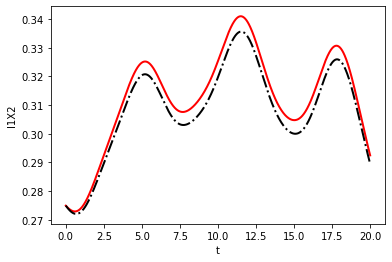

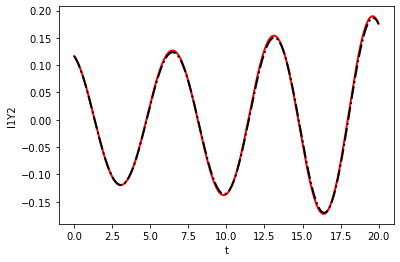

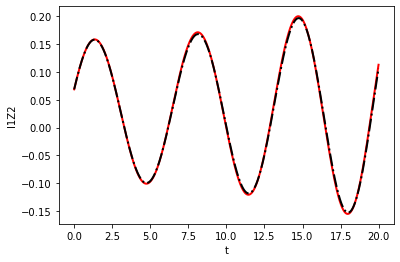

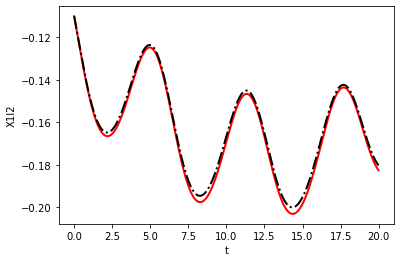

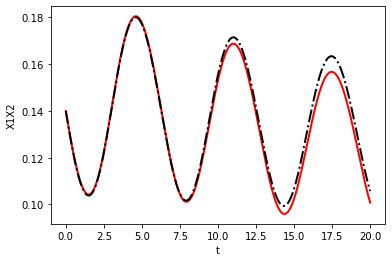

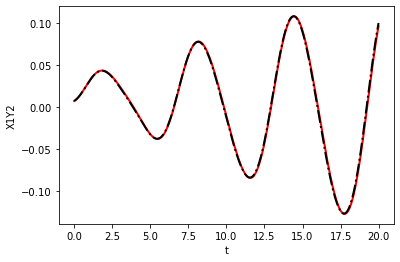

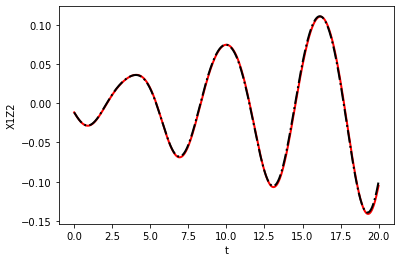

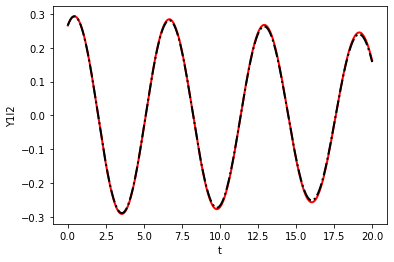

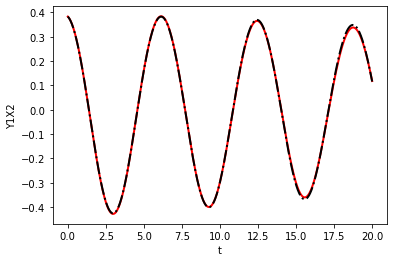

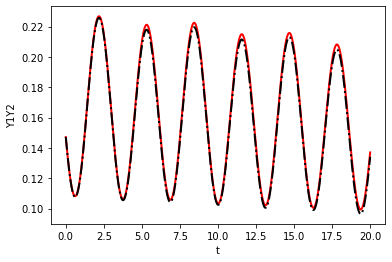

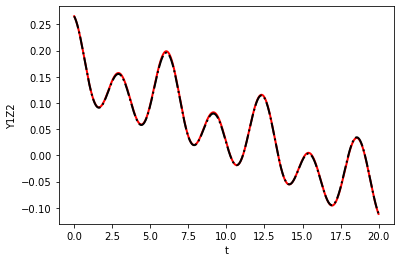

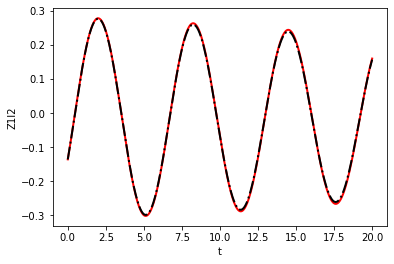

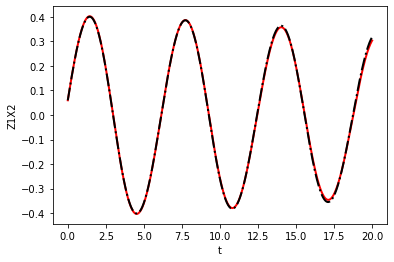

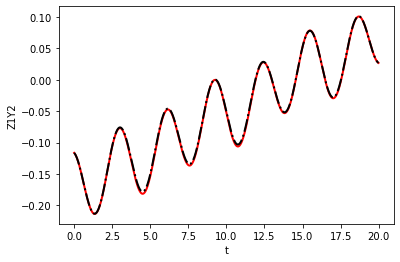

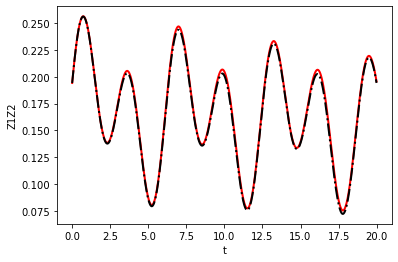

In [138]:
#Plots
for i in range(15):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x3=[x[i] for x in arr]
    x31=[x[i] for x in temp1]
    ax.plot(temp, x3, 'r-', linewidth=2)
    ax.plot(temp, x31, 'k-.', linewidth=2)
    ax.set_xlabel('t')
    ax.set_ylabel(names_pauli2[i+1])
    plt.show()



    
    

# 